In [ ]:
import numpy as np
import math
from fractions import Fraction
import itertools
from biotuner_utils import *
from biotuner_offline import *
import matplotlib.pyplot as plt
from numpy import array, zeros, ones, arange, log2, sqrt, diff, concatenate
import emd
from PyEMD import EMD, EEMD
from scipy.signal import butter, lfilter
import colorednoise as cn
from biotuner import *
import mne

## Load dataset

In [ ]:

#path = 'D:/Science/EEG_data/'
path = 'C:/Users/Dell/GitHub/CoCoBrainChannel/'
epochs = mne.read_epochs(path+'pareidolia_run2.fif')
#epochs = mne.read_epochs('C:/Users/Antoine/github/Data_EEG/pareidolia_run1.fif')
epochs = epochs.apply_baseline((-1.5, -0.1))
#epochs = epochs.crop(0.5, 7.5)
epochs_data = epochs.get_data()

## Initialize biotuner object and methods

In [5]:
class biotuner(object):
    
    '''Class used to derive peaks information, musical scales and related metrics from time series  
    
    Example of use:       
    biotuning = biotuner(sf = 1000)
    biotuning.peaks_extraction(data)
    biotuning.peaks_extension()
    biotuning.peaks_metrics()
    '''
    
    def __init__(self, sf, peaks_function = 'EEMD', precision = 0.2, compute_sub_ratios = False, 
                 n_harm = 10, harm_function = 'mult', extension_method = 'consonant_harmonic_fit'):
        '''Initializing sampling frequency'''
        self.sf = sf
        '''Initializing arguments for peak extraction
           peaks_function: method used to extract the peaks ['EEMD', 'EMD', 'HH1D_max', 'adapt', 'fixed']
           precision: precision of the peaks in Hz
           compute_sub_ratios: when set to True, include ratios < 1 in peaks_ratios attribute [True, False]'''
        self.peaks_function = peaks_function
        self.precision = precision
        self.compute_sub_ratios = compute_sub_ratios
        '''Initializing arguments for peaks metrics
           n_harm: number of harmonics to compute in harmonic_fit function
           harm_function: compute harmonics from iterative multiplication (x, 2x, 3x, ...nx) or division (x, x/2, x/3, ...x/n) ['mult', 'div']
           extension_method: ['harmonic_fit', 'consonant', 'multi_consonant', 'consonant_harmonic_fit', 'multi_consonant_harmonic_fit']'''
        self.n_harm = n_harm
        self.harm_function = harm_function
        self.extension_method = extension_method
        '''Initializing dictionary for scales metrics'''
        self.scale_metrics = {}
    
    '''First method to use. Requires data as input argument
       Generates self.peaks and self.peaks_ratios attributes'''
    
    def peaks_extraction (self, data, peaks_function = None, FREQ_BANDS = None, precision = None, sf = None, max_freq = 80, compute_sub_ratios = None):
        if sf == None:
            sf = self.sf
        if precision == None:
            precision = self.precision
        if peaks_function == None:
            peaks_function = self.peaks_function
        if compute_sub_ratios == None:
            compute_sub_ratios = self.compute_sub_ratios
        self.peaks, self.amps = compute_peaks_ts (data, peaks_function = peaks_function, FREQ_BANDS = None, precision = precision, sf = sf, max_freq = max_freq)

        self.peaks_ratios = compute_peak_ratios(self.peaks, rebound = True, octave = 2, sub = compute_sub_ratios)
        
    '''Generates self.extended_peaks and self.extended_peaks_ratios attributes'''
    
    def peaks_extension (self, peaks = None, n_harm = None, method = None, harm_function = 'mult', cons_limit = 0.1):
        if peaks == None:
            peaks = self.peaks
        if n_harm == None:
            n_harm = self.n_harm
        if method == None:
            method = self.extension_method
        if method == 'harmonic_fit':
            extended_peaks = harmonic_fit(peaks, self.n_harm, function = harm_function, div_mode = 'div_add')
            self.extended_peaks = np.sort(list(self.peaks)+list(extended_peaks))
        if method == 'consonant':
            consonance, cons_pairs, cons_peaks, cons_metric = consonance_peaks (peaks, limit = cons_limit)
            self.extended_peaks = np.sort(np.round(cons_peaks, 3))
        if method == 'multi_consonant':
            consonance, cons_pairs, cons_peaks, cons_metric = consonance_peaks (peaks, limit = cons_limit)
            self.extended_peaks = np.sort(np.round(multi_consonance(cons_pairs, n_freqs = 10), 3))
        if method == 'consonant_harmonic_fit':
            extended_peaks = harmonic_fit(peaks, self.n_harm, function = harm_function, div_mode = 'div_add')
            consonance, cons_pairs, cons_peaks, cons_metric = consonance_peaks (extended_peaks, limit = cons_limit)
            self.extended_peaks = np.sort(np.round(cons_peaks, 3))
        if method == 'multi_consonant_harmonic_fit':
            extended_peaks = harmonic_fit(peaks, self.n_harm, function = harm_function)
            consonance, cons_pairs, cons_peaks, cons_metric = consonance_peaks (extended_peaks, limit = cons_limit)
            self.extended_peaks = np.sort(np.round(multi_consonance(cons_pairs, n_freqs = 10), 3))
        self.extended_peaks_ratios = compute_peak_ratios(self.extended_peaks)
      
    def compute_peaks_metrics (self, n_harm = None):
        if n_harm == None:
            n_harm = self.n_harm
            
        peaks = list(self.peaks)
        metrics = {'cons' : 0, 'euler' : 0, 'tenney': 0, 'harm_fit': 0}   
        metrics['harm_fit'] = len(harmonic_fit(peaks, n_harm = n_harm))
        a, b, c, metrics['cons'] = consonance_peaks (peaks, 0.1)
        peaks_euler = [int(round(num, 2)*1000) for num in peaks]
        metrics['euler'] = euler(*peaks_euler)
        metrics['tenney'] = tenneyHeight(peaks)
        metrics_list = []
        for value in metrics.values():
            metrics_list.append(value)
        self.peaks_metrics_list = metrics_list
        self.peaks_metrics = metrics

    '''Methods to compute scales from whether peaks or extended peaks'''
    
    def compute_diss_curve (self, input_type = 'peaks', denom=1000, max_ratio=2, consonance = True, method = 'min', plot = False):
        if input_type == 'peaks':
            peaks = self.peaks
            amps = self.amps
        if input_type == 'extended_peaks':
            peaks = self.extended_peaks
            amps = self.extended_amps

        peaks = [p*128 for p in peaks]
        amps = np.interp(self.amps, (np.array(self.amps).min(), np.array(self.amps).max()), (0.2, 0.8))
        intervals, self.diss_scale, euler_diss, diss, harm_sim_diss = diss_curve (peaks, amps, denom=denom, max_ratio=max_ratio, consonance = consonance, method = method, plot = plot)
        self.scale_metrics['diss_euler'] = euler_diss
        self.scale_metrics['dissonance'] = diss
        self.scale_metrics['diss_harm_sim'] = np.average(harm_sim_diss)
        self.scale_metrics['diss_n_steps'] = len(self.diss_scale)
        
    def compute_harmonic_entropy(self, input_type = 'peaks', res = 0.001, spread = 0.01, plot_entropy = True, plot_tenney = False):
        if input_type == 'peaks':
            ratios = self.peaks_ratios
        if input_type == 'extended_peaks':
            ratios = self.extended_peaks_ratios
            #print(ratios)
        HE_scale, HE = harmonic_entropy(ratios, res = res, spread = spread, plot_entropy = plot_entropy, plot_tenney = plot_tenney)
        self.HE_scale = HE_scale[0]
        self.scale_metrics['HE'] = HE
        self.scale_metrics['HE_n_steps'] = len(self.HE_scale)  
        self.scale_metrics['HE_harm_sim'] = np.average(ratios2harmsim(list(biotuning.HE_scale)))
        '''
        ratios_euler = [a]+ratios
        ratios_euler = [int(round(num, 2)*1000) for num in ratios]
        euler_score = None
        if consonance == True:
            euler_score = euler(*ratios_euler)
            euler_score = euler_score/len(diss_minima)
        '''
    
    '''Generic method to fit all Biotuner methods'''
    
    def fit_all(self, data, compute_diss = True, compute_HE = True, compute_peaks_extension = True):
        biotuning = biotuner(self.sf, peaks_function = self.peaks_function, precision = self.precision, n_harm = self.n_harm)
        biotuning.peaks_extraction(data)
        biotuning.compute_peaks_metrics()
        if compute_diss == True:
            biotuning.compute_diss_curve(input_type = 'peaks', plot = False)
        if compute_peaks_extension == True:
            biotuning.peaks_extension(method = 'multi_consonant_harmonic_fit', harm_function = 'mult', cons_limit = 0.01)
        if compute_HE == True:
            biotuning.compute_harmonic_entropy(input_type = 'extended_peaks', plot_entropy = False)
        return biotuning
    
    def info(self, metrics=False, scales=False, whatever=False):
        if metrics == True:
            print('METRICS')
            print(vars(self))
        
        else:
            print(vars(self))
        return

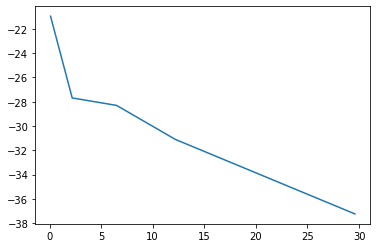

In [18]:
pos = biotuning.peaks
values = biotuning.amps
plt.plot(pos, values)

array([ 0.8,  2.2,  6.5, 22.6, 48.4])

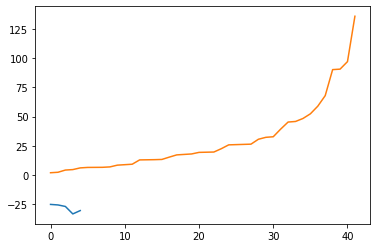

In [15]:
plt.plot(biotuning.amps)
plt.plot(biotuning.extended_peaks)
biotuning.peaks

[ -82.40591983  -60.15184855  -51.47482804 ... -124.05682191 -130.62537104
 -129.36244257]
[ -65.02427182  -50.74404735  -48.81719544 ... -154.26901748 -150.97670829
 -157.02285528]
[ -55.59509776  -50.70537411  -47.09480413 ... -182.76122277 -193.1314183
 -200.38138274]
[ -45.06621692  -39.06939927  -43.04135285 ... -207.0376273  -203.82577728
 -204.34573564]
[ -40.81019488  -20.95768221  -22.04961438 ... -233.36327162 -238.16620526
 -241.63700792]
[1.35, 1.88, 2.0]


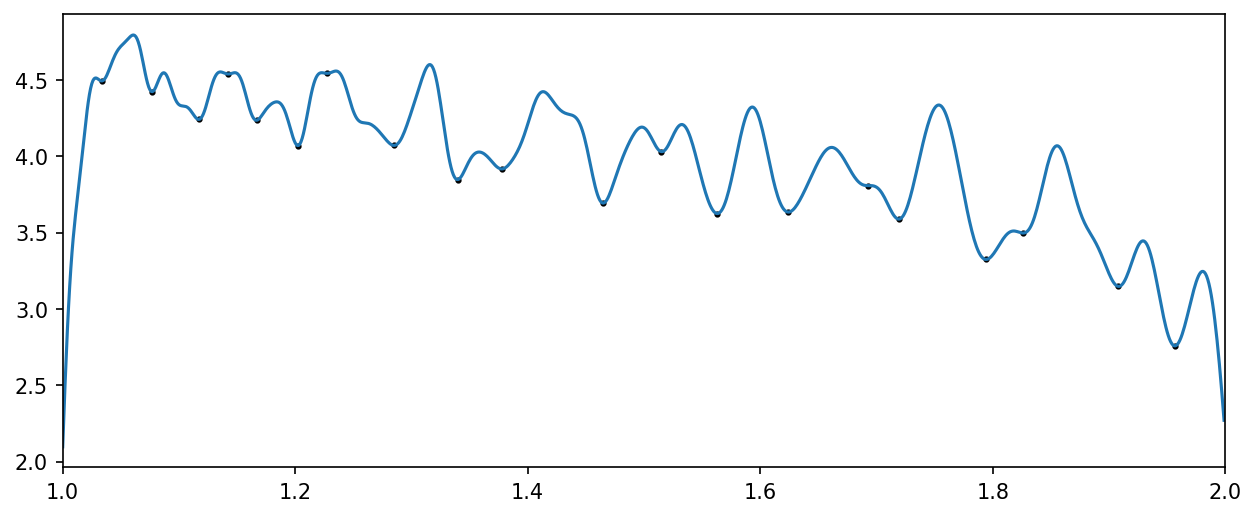

In [17]:

data = epochs_data[35][15] # Define data (single time series)
biotuning = biotuner(1000, peaks_function = 'EMD', precision = 0.1, n_harm = 40) # Initialize biotuner object
biotuning.peaks_extraction(data)
biotuning.compute_peaks_metrics()
biotuning.peaks_extension(method = 'consonant_harmonic_fit', harm_function = 'mult', cons_limit = 0.1)
biotuning.compute_diss_curve(plot = False, input_type = 'peaks')

biotuning.compute_harmonic_entropy(input_type = 'extended_peaks', plot_entropy = True)

In [ ]:
biotuning.scale_metrics

In [ ]:
a, b, c = oct_subdiv(3/2,0.01367,2,10)
m = compare_oct_div(Octdiv = 53, Octdiv2 = 12, bounds = 0.003, octave = 2)
m

In [ ]:
#a, b = multi_oct_subdiv (biotuning.peaks, 200, 0.01)
a

In [ ]:
def multi_oct_subdiv (peaks, max_sub, octave_limit, octave = 2, n_scales = 10):
    import itertools
    from collections import Counter
    a, b, pairs, cons = consonance_peaks(peaks, 0.01)
    ratios, cons = consonant_ratios(peaks, 0.01)
    print(ratios)
    list_oct_div = []
    for i in range(len(ratios)):
        list_temp, no= oct_subdiv(ratios[i], octave_limit, octave, n_scales)
        print(list_temp)
        list_oct_div.append(list_temp)


    counts = Counter(list(itertools.chain(*list_oct_div)))
    oct_div_temp = []
    for k, v in counts.items():
        if v > 1:
            oct_div_temp.append(k)
    oct_div_temp = np.sort(oct_div_temp)
    oct_div_final = []
    for i in range(len(oct_div_temp)):
        if oct_div_temp[i] < max_sub:
            oct_div_final.append(oct_div_temp[i])
    return oct_div_final, ratios

In [ ]:
biotuning.HE_scale

In [ ]:
biotuning = biotuner(1000, peaks_function = 'adapt', precision = 0.1, n_harm = 30)
biotuning = biotuning.fit_all(data)
biotuning.peaks_ratios

In [ ]:
vars(biotuning)
#biotuning.HE_scale